In [1]:
!pip install transformers wikipedia newspaper3k GoogleNews pyvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 29.5 MB/s 
     |████████████████████████████████| 211 kB 54.0 MB/s 
     |████████████████████████████████| 592 kB 61.4 MB/s 
     |████████████████████████████████| 7.6 MB 52.4 MB/s 
     |████████████████████████████████| 163 kB 56.9 MB/s 
     |████████████████████████████████| 7.4 MB 14.1 MB/s 
     |████████████████████████████████| 81 kB 9.7 MB/s 
     |████████████████████████████████| 93 kB 1.7 MB/s 
     |████████████████████████████████| 290 kB 12.2 MB/s 
     |████████████████████████████████| 1.6 MB 62.4 MB/s 
     |████████████████████████████████| 749 kB 66.8 MB/s 
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11695 sha256=e4b531e63903689eface27fdfee5c48c973984d1953c861fd80c9e0c886629f6
  Stored in directory: /root/.cache/pip/wheels/15/93/6d/5b2c68b8a64c7a7a04947b4ed6d89fb557dcc6bc27d1d7f3ba
  Cr

In [2]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import math
import torch
import wikipedia
from newspaper import Article, ArticleException
from GoogleNews import GoogleNews
import IPython
from pyvis.network import Network

# Load the model

In [3]:
# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")

Downloading:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/123 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/344 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

In [4]:
def extract_relations_from_model_output(text):
  # <triplet> Army of Darkness <subj> 1992 <obj> publication date <subj> comedy horror <obj> genre <subj> Sam Raimi <obj> director <subj> Robert Tapert <obj> producer <subj> Bruce Campbell <obj> producer <subj> Ivan Raimi <obj> screenwriter
    relations = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    text_replaced = text.replace("<s>", "").replace("<pad>", "").replace("</s>", "")
    print(text_replaced)
    for token in text_replaced.split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        relations.append({
            'head': subject.strip(),
            'type': relation.strip(),
            'tail': object_.strip()
        })
    return relations

In [22]:
import spacy
class KB():
    def __init__(self, text):
        self.relations = []
        self.nlp = spacy.load("en_core_web_sm")

    def are_relations_equal(self, r1, r2):
        return all(r1[attr] == r2[attr] for attr in ["head", "type", "tail"])

    def exists_relation(self, r1):
        return any(self.are_relations_equal(r1, r2) for r2 in self.relations)

    def add_relation(self, r):
        if not self.exists_relation(r):
            self.relations.append(r)

    def print(self):
        print("Relations:")
        for r in self.relations:
            print(f"  {r}")

    def get_useful_info(self):
      useful = []
      for r in self.relations:
        print(r['type'])
        if r['type'] == 'genre':
          if self.nlp(r['head']).ents and self.nlp(r['head']).ents[0].label_ == 'PERSON':
            continue
          elif self.nlp(r['tail']).ents and self.nlp(r['tail']).ents[0].label_ == 'PERSON':
            continue
          else:
            useful.append(r)
        elif r['type'] == 'director':
           useful.append(r)
        elif r['type'] == 'cast member':
           useful.append(r)
          
      return useful

In [ ]:
# import spacy
# nlp = spacy.load("en_core_web_sm")
# nlp('Morris Ankrum').ents[0].label_

'PERSON'

In [6]:
import spacy

def from_small_text_to_kb(text, verbose=False):
    kb = KB(text)

    # Tokenizer text
    model_inputs = tokenizer(text, max_length=512, padding=True, truncation=True,
                            return_tensors='pt')
    if verbose:
        print(f"Num tokens: {len(model_inputs['input_ids'][0])}")
    # print(model_inputs)

    # Generate
    gen_kwargs = {
        "max_length": 216,
        "length_penalty": 0,
        "num_beams": 3,
        "num_return_sequences": 3
    }
    generated_tokens = model.generate(
        **model_inputs,
        **gen_kwargs,
    )
    decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)

    # create kb
    for sentence_pred in decoded_preds:
        relations = extract_relations_from_model_output(sentence_pred)
        for r in relations:
            kb.add_relation(r)

    return kb

# Example with data partition 4 (中期)

In [ ]:
import pickle
df=open('/content/raw_data_4','rb')
film_data=pickle.load(df)
df.close()

In [ ]:
film_data[0]

{'id': '45596993',
 'revid': '39239779',
 'url': 'https://en.wikipedia.org/wiki?curid=45596993',
 'title': "Scatter My Ashes at Bergdorf's",
 'text': '"Scatter My Ashes at Bergdorf\'s" is a US 2013 documentary feature directed by Matthew Miele about the New York City luxury goods department store Bergdorf Goodman, situated on Fifth Avenue where it meets Grand Army Plaza. The film\'s title is lifted from the caption of a 1990 Victoria Roberts cartoon that appeared in pages of "The New Yorker". The film features celebrities, store executives and employees, designers and customers testifying to their love of the place.\nThe film opened at theatres on May 3, 2013.'}

In [ ]:
kbs = []
for film in film_data[:10]:
  text = film['text']
  kb = from_small_text_to_kb(text, verbose=True)
  kbs.extend(kb.get_useful_info())

kbs

Num tokens: 109
<triplet> Scatter My Ashes at Bergdorf's <subj> 2013 <obj> publication date
<triplet> Scatter My Ashes at Bergdorf's <subj> 2013 <obj> publication date <subj> Matthew Miele <obj> director
<triplet> Scatter My Ashes at Bergdorf's <subj> 2013 <obj> publication date <subj> Matthew Miele <obj> director <triplet> Bergdorf Goodman <subj> New York City <obj> headquarters location <triplet> Fifth Avenue <subj> New York City <obj> located in the administrative territorial entity
Num tokens: 512
<triplet> Paul and Virginia <subj> 1910 <obj> publication date
<triplet> Paul and Virginia <subj> 1910 <obj> publication date <subj> Thanhouser Company <obj> production company <triplet> Paul et Virginie <subj> Jacques-Henri Bernardin de Saint-Pierre <obj> author
<triplet> Paul and Virginia <subj> 1910 <obj> publication date <subj> silent <obj> genre <subj> Thanhouser Company <obj> production company <triplet> Paul et Virginie <subj> Jacques-Henri Bernardin de Saint-Pierre <obj> author
Nu

[{'head': "Scatter My Ashes at Bergdorf's",
  'type': 'director',
  'tail': 'Matthew Miele'},
 {'head': "A Doctor's Diary", 'type': 'genre', 'tail': 'drama film'},
 {'head': "A Doctor's Diary", 'type': 'director', 'tail': 'Charles Vidor'},
 {'head': 'Borderland', 'type': 'director', 'tail': 'Nate Watt'},
 {'head': 'The Crime Nobody Saw', 'type': 'genre', 'tail': 'comedy film'},
 {'head': 'The Crime Nobody Saw',
  'type': 'director',
  'tail': 'Charles Barton'},
 {'head': 'Hills of Old Wyoming', 'type': 'director', 'tail': 'Nate Watt'},
 {'head': 'Crazy Bitches', 'type': 'genre', 'tail': 'comedy horror'},
 {'head': 'North of the Rio Grande', 'type': 'director', 'tail': 'Nate Watt'}]

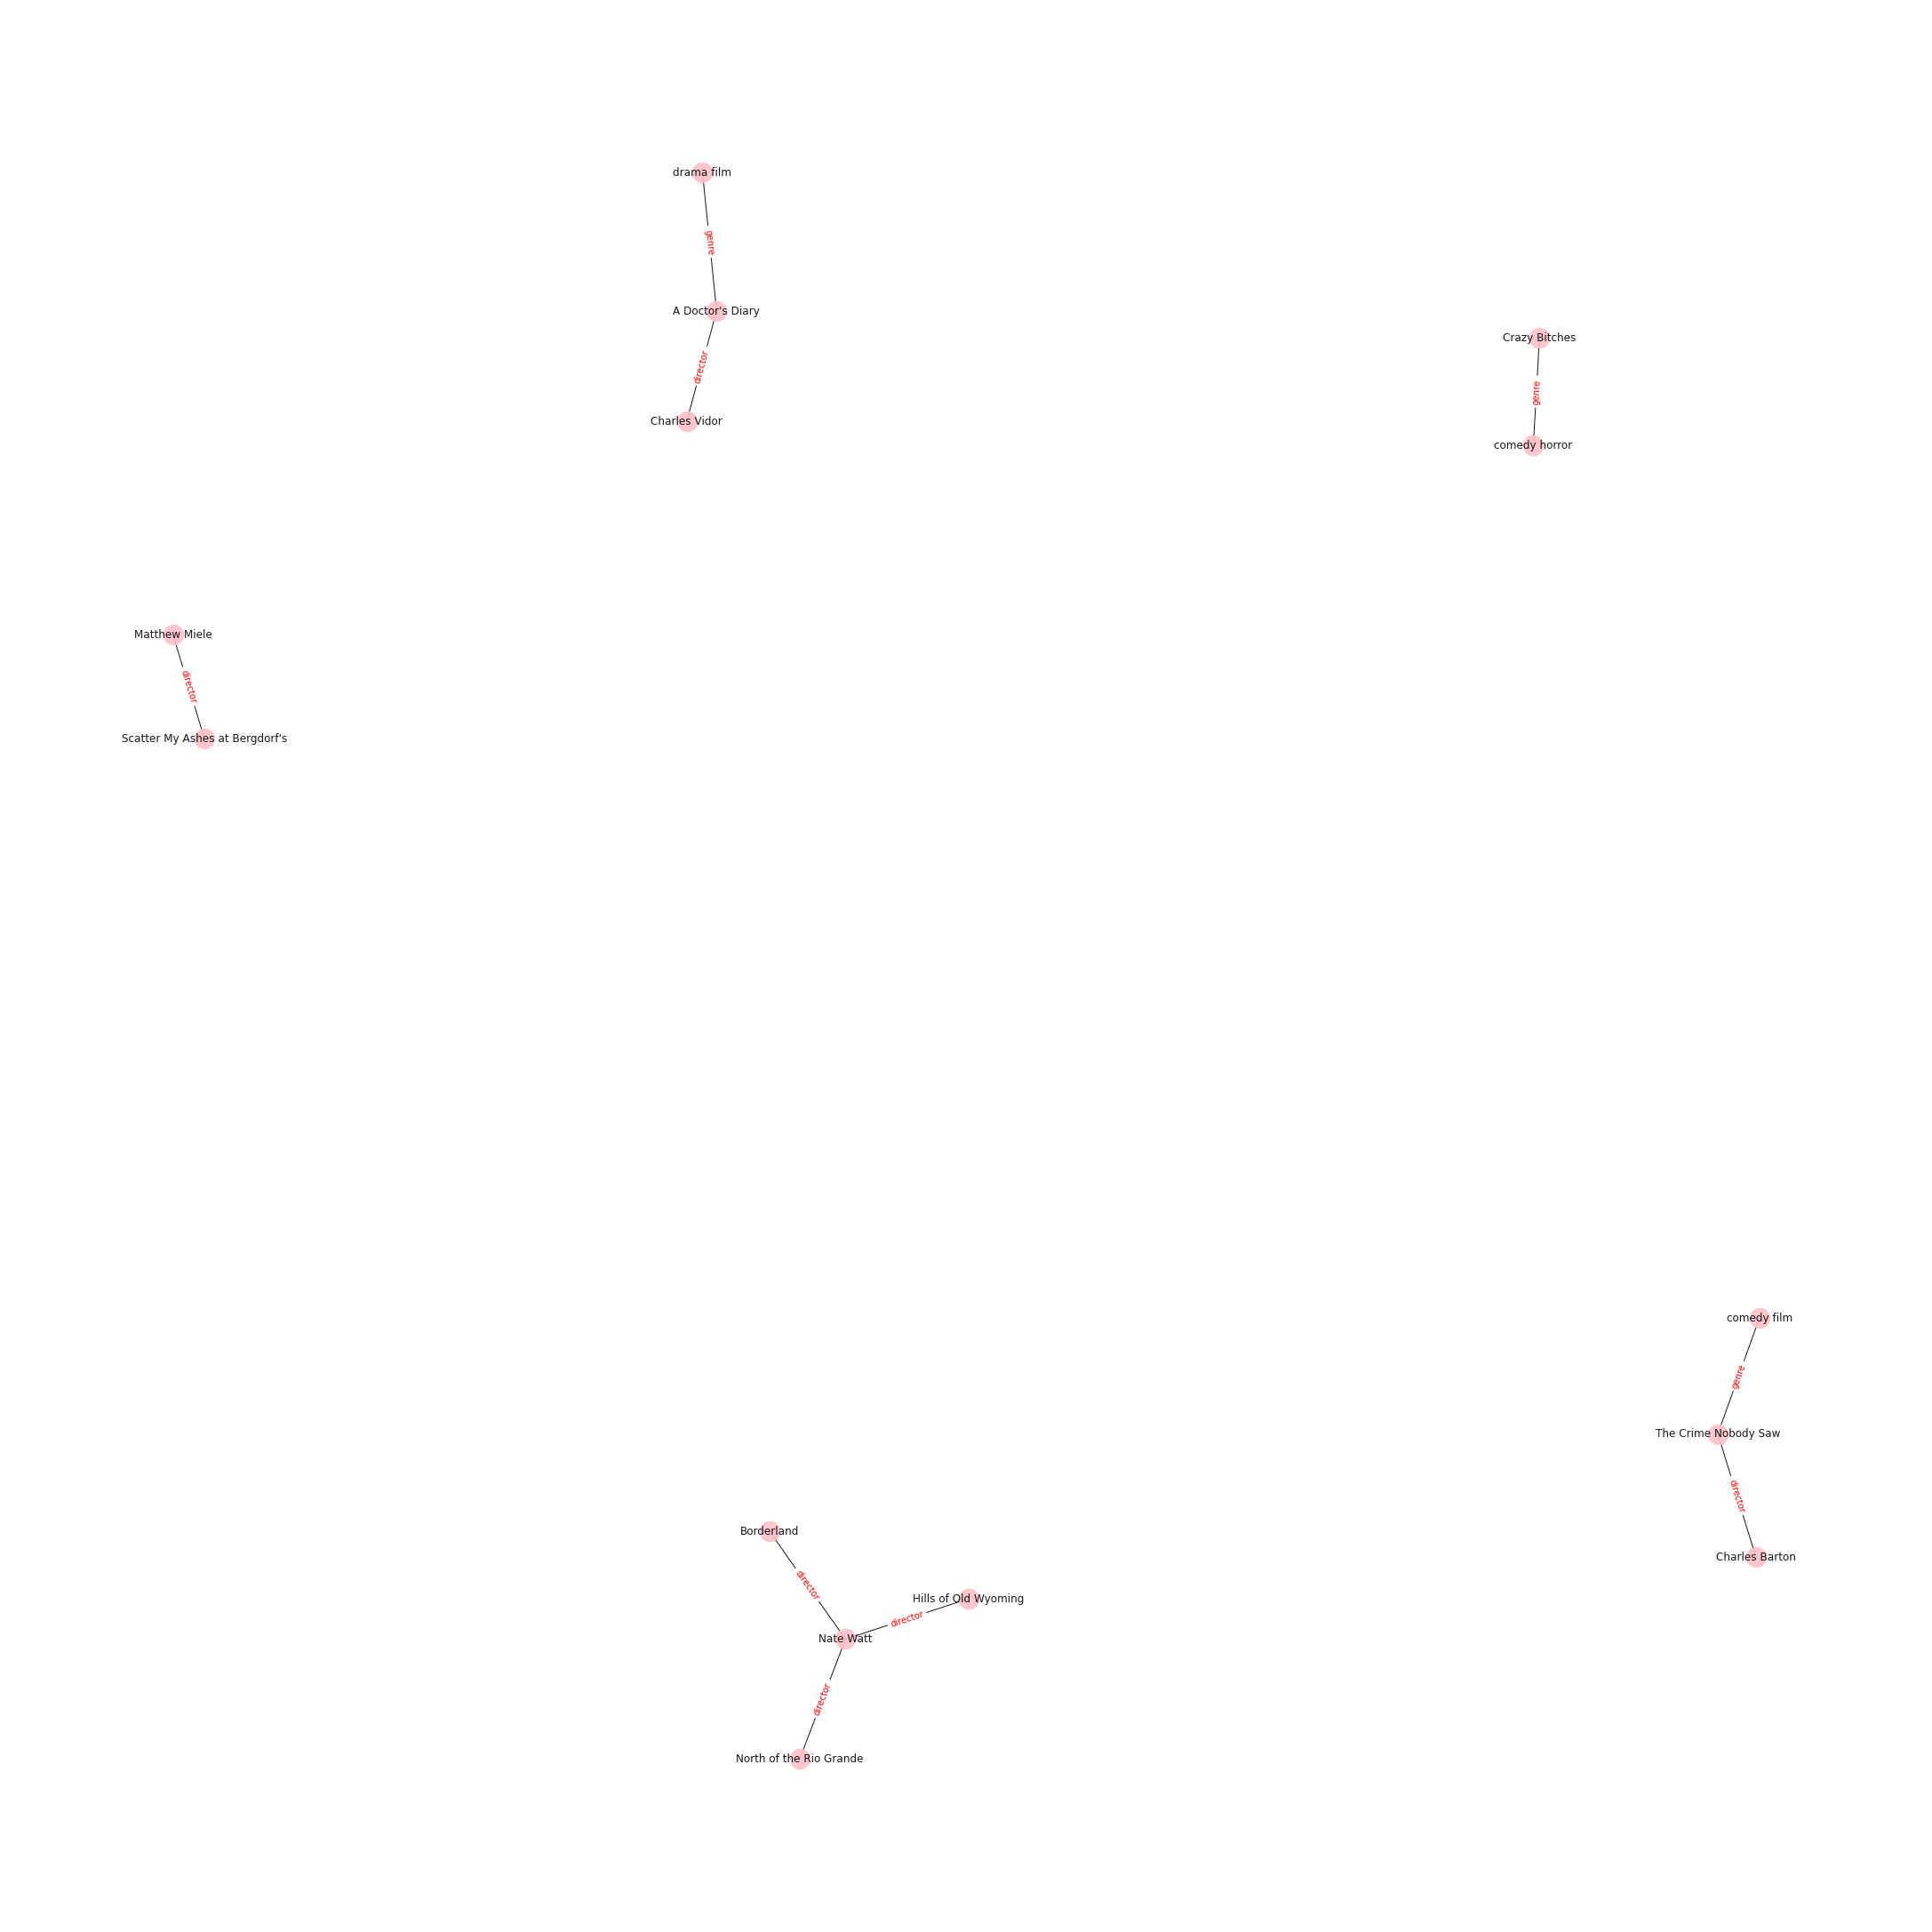

In [ ]:
# extract subject
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

edges = []
edge_labels = {}
for item in kbs:
  edges.append([item['head'], item['tail']])
  edge_labels[(item['head'], item['tail'])] = item['type']

G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
plt.figure(figsize=(30,30))
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_color='red'
)
plt.axis('off')
plt.show()

# Evaluation with manually-annotated dataset （same data structure as bert）

In [118]:
import pickle

df=open('annotated_34.pickle','rb')
film_data=pickle.load(df)
df.close()

In [119]:
# change the types in spo list from labeled dataset to fit the format in rebel
spo_list = []
for film in film_data:
  spo = film["spo_list"]
  for i,item in enumerate(spo):
    if item[1]=="is_genre":
      spo[i][1]="genre"
      print(spo[i][2])
      spo[i][2]=spo[i][2]+" film"
    elif item[1]=="direct":
      spo[i][1]="director"
    elif item[1] == "act":
      spo[i][1]="cast member"
    spo_set = set()
    spo_set.update((spo[i][0],spo[i][1],spo[i][2]))
    spo_list.append(spo_set)

spo_list

comedy
musical
horror
vigilante action thriller
pre-Code
comedy
crime thriller
crime thriller
drama/thriller
made-for-television drama
comedy
science-fiction horror
comedy/drama
historical drama television
documentary
drama
feature-length documentary
comedy horror
made-for-television drama
crime
computer animated short film
thriller
drama
biographical film
made-for-television drama
made-for-television drama
documentary
Technicolor Western
independent
drama
Christian drama
television 
television
independent 


[{"Brewster's Millions", 'comedy film', 'genre'},
 {"Brewster's Millions", 'Eddie "Rochester" Anderson', 'cast member'},
 {'Fruit Fly', 'genre', 'musical film'},
 {'Fruit Fly', 'H.P. Mendoza', 'director'},
 {'Night of the Demons', 'genre', 'horror film'},
 {'Adam Gierasch', 'Night of the Demons', 'director'},
 {'Edward Furlong', 'Night of the Demons', 'cast member'},
 {'Monica Keena', 'Night of the Demons', 'cast member'},
 {'Bobbi Sue Luther', 'Night of the Demons', 'cast member'},
 {'Night of the Demons', 'Shannon Elizabeth', 'cast member'},
 {'Diora Baird', 'Night of the Demons', 'cast member'},
 {'Michael Copon', 'Night of the Demons', 'cast member'},
 {'Law Abiding Citizen', 'genre', 'vigilante action thriller film'},
 {'Gerard Butler', 'Law Abiding Citizen', 'cast member'},
 {'Jamie Foxx', 'Law Abiding Citizen', 'cast member'},
 {'Frank R. Strayer', 'Manhattan Tower', 'director'},
 {'Manhattan Tower', 'Mary Brian', 'cast member'},
 {'James Hall', 'Manhattan Tower', 'cast member'}

In [ ]:
# generate a list of kbs
kbs = []
kbs_list = []
for film in film_data:
  relations = []
  text = film['text']
  # spo_list = film["spo_list"]
  # print(text)
  # print(spo_list)
  kb = from_small_text_to_kb(text, verbose=True)
  kbs.extend(kb.get_useful_info())
  # print(kbs[0])

kbs

In [122]:
# change each element of kb_list (list->set)
kb_list = []
for kb in kbs:
  spo = set()
  spo.update((kb["head"],kb["type"],kb["tail"]))
  kb_list.append(spo)

In [125]:
kb_list

[{"Brewster's Millions", 'comedy film', 'genre'},
 {'Edward Furlong', 'Night of the Demons', 'cast member'},
 {'Night of the Demons', 'genre', 'horror film'},
 {'Monica Keena', 'Night of the Demons', 'cast member'},
 {'Bobbi Sue Luther', 'Night of the Demons', 'cast member'},
 {'Night of the Demons', 'Shannon Elizabeth', 'cast member'},
 {'Diora Baird', 'Night of the Demons', 'cast member'},
 {'Gerard Butler', 'Law Abiding Citizen', 'cast member'},
 {'Jamie Foxx', 'Law Abiding Citizen', 'cast member'},
 {'Manhattan Tower', 'Mary Brian', 'cast member'},
 {'James Hall', 'Manhattan Tower', 'cast member'},
 {'Ready? OK!', 'comedy film', 'genre'},
 {'Carrie Preston', 'Ready? OK!', 'cast member'},
 {'Black Day Blue Night', 'Gil Bellows', 'cast member'},
 {'Black Day Blue Night', 'Michelle Forbes', 'cast member'},
 {'Black Day Blue Night', 'Mia Sara', 'cast member'},
 {'Black Day Blue Night', 'John Beck', 'cast member'},
 {'Billy Zane', 'The Set-Up', 'cast member'},
 {'Strathford Hamilton', '

In [126]:
spo_list

[{"Brewster's Millions", 'comedy film', 'genre'},
 {"Brewster's Millions", 'Eddie "Rochester" Anderson', 'cast member'},
 {'Fruit Fly', 'genre', 'musical film'},
 {'Fruit Fly', 'H.P. Mendoza', 'director'},
 {'Night of the Demons', 'genre', 'horror film'},
 {'Adam Gierasch', 'Night of the Demons', 'director'},
 {'Edward Furlong', 'Night of the Demons', 'cast member'},
 {'Monica Keena', 'Night of the Demons', 'cast member'},
 {'Bobbi Sue Luther', 'Night of the Demons', 'cast member'},
 {'Night of the Demons', 'Shannon Elizabeth', 'cast member'},
 {'Diora Baird', 'Night of the Demons', 'cast member'},
 {'Michael Copon', 'Night of the Demons', 'cast member'},
 {'Law Abiding Citizen', 'genre', 'vigilante action thriller film'},
 {'Gerard Butler', 'Law Abiding Citizen', 'cast member'},
 {'Jamie Foxx', 'Law Abiding Citizen', 'cast member'},
 {'Frank R. Strayer', 'Manhattan Tower', 'director'},
 {'Manhattan Tower', 'Mary Brian', 'cast member'},
 {'James Hall', 'Manhattan Tower', 'cast member'}

In [123]:
# count the length of intersection between spo_list and kb_list 
def find_intersection(spo_list,kb_list):
  int_count = 0
  for item in spo_list:
    if item in kb_list:
      int_count+=1
  return int_count

int_count = find_intersection(spo_list,kb_list)
label_count = len(spo_list)
result_count = len(kb_list)

In [124]:
print(int_count,result_count,label_count)
f1, precision, recall = 2 * int_count / (result_count + label_count), int_count / result_count, int_count / label_count # f1 精准度 召回率
print(f1, precision, recall)

82 90 134
0.7321428571428571 0.9111111111111111 0.6119402985074627
